In [1]:
import torch 
import torchvision
import torch.nn as nn
import torch.nn.functional as functional
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
raw_data = np.load("data.npy")

In [3]:

classes = ['frame_num', 'action', 'team_controlling_ball', 'ball_x', 'ball_y', 'num_players_team1', 'num_players_team2', 'scene', 'no_team1_players']

for i in range(11):
    classes.append('team1_player' + str(i) + 'x')
    classes.append('team1_player' + str(i) + 'y')

classes.append('no_team1_players')

for i in range(11):
    classes.append('team2_player' + str(i) + 'x')
    classes.append('team2_player' + str(i) + 'y')
    
class_by_name = {} 
for i, item in enumerate(classes):
    class_by_name[item] = i

print(class_by_name)


{'frame_num': 0, 'action': 1, 'team_controlling_ball': 2, 'ball_x': 3, 'ball_y': 4, 'num_players_team1': 5, 'num_players_team2': 6, 'scene': 7, 'no_team1_players': 31, 'team1_player0x': 9, 'team1_player0y': 10, 'team1_player1x': 11, 'team1_player1y': 12, 'team1_player2x': 13, 'team1_player2y': 14, 'team1_player3x': 15, 'team1_player3y': 16, 'team1_player4x': 17, 'team1_player4y': 18, 'team1_player5x': 19, 'team1_player5y': 20, 'team1_player6x': 21, 'team1_player6y': 22, 'team1_player7x': 23, 'team1_player7y': 24, 'team1_player8x': 25, 'team1_player8y': 26, 'team1_player9x': 27, 'team1_player9y': 28, 'team1_player10x': 29, 'team1_player10y': 30, 'team2_player0x': 32, 'team2_player0y': 33, 'team2_player1x': 34, 'team2_player1y': 35, 'team2_player2x': 36, 'team2_player2y': 37, 'team2_player3x': 38, 'team2_player3y': 39, 'team2_player4x': 40, 'team2_player4y': 41, 'team2_player5x': 42, 'team2_player5y': 43, 'team2_player6x': 44, 'team2_player6y': 45, 'team2_player7x': 46, 'team2_player7y':

In [4]:

for i, value in enumerate(raw_data[0]):
    print(f"idx {i}\t name: {classes[i]}\t\t\tvalue: {value}")

idx 0	 name: frame_num			value: 8707.0
idx 1	 name: action			value: 19
idx 2	 name: team_controlling_ball			value: 2.0
idx 3	 name: ball_x			value: 0.4796875
idx 4	 name: ball_y			value: 0.5388888888888889
idx 5	 name: num_players_team1			value: 6.0
idx 6	 name: num_players_team2			value: 11.0
idx 7	 name: scene			value: Midfield
idx 8	 name: no_team1_players			value: 6.0
idx 9	 name: team1_player0x			value: 0.809375
idx 10	 name: team1_player0y			value: 0.3763888888888889
idx 11	 name: team1_player1x			value: 0.96875
idx 12	 name: team1_player1y			value: 0.6041666666666666
idx 13	 name: team1_player2x			value: 0.4640625
idx 14	 name: team1_player2y			value: 0.40694444444444444
idx 15	 name: team1_player3x			value: 0.78828125
idx 16	 name: team1_player3y			value: 0.45416666666666666
idx 17	 name: team1_player4x			value: 0.4390625
idx 18	 name: team1_player4y			value: 0.44166666666666665
idx 19	 name: team1_player5x			value: 0.71171875
idx 20	 name: team1_player5y			value: 0.49027777777

In [5]:
import os
from torch.utils.data import Dataset

class FootballData(Dataset):

    def idx_to_name(self, idx):
        return f"{self.out_path}/record{idx}.npy"
    
    def __init__(self, path, out_path):
        self.out_path = out_path if out_path else './barca_dataset'
        raw_data = np.load(path)
        self.size = len(raw_data)
        if not os.path.isdir(self.out_path):
            os.mkdir(self.out_path)
        for i, record in enumerate(raw_data):
            name = self.idx_to_name(i)
            if not os.path.isfile(name):
                np.save(name, record)

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        # data = np.load("./barca_dataset/record" + str(idx) + ".npy")
        idx = random.randint(0,41)
        data = np.load(self.idx_to_name(idx))
        # inputs = np.concatenate( (data[9:31], data[32:], data[3:5])).astype(np.float32) #todo we need to check those indecies
        inputs = [(float(data[3])),(float(data[4]))]
        inputs = np.array([inputs],dtype=np.float32)
        inputs = torch.from_numpy(inputs)
        # if data[2] == 0:
        #     inputs = torch.Tensor([[1,0]])
        # else:
        #     inputs = torch.Tensor([[0,1]])
        # label = np.array([[0.0 for x in range(41)]])
        # label[0,int(data[1])] = 10.0
        label = torch.from_numpy(np.array([int(data[1])]))
        return inputs.float(), label

In [6]:
data_loader = FootballData("./data.npy", out_path="data_unloaded")

In [7]:
class PossesionClssifier(nn.Module):
    def __init__(self):
      super(PossesionClssifier,self).__init__()
      self.stack = nn.Sequential(
        nn.Linear(2,30,bias=False),
        nn.ReLU(),
        nn.Linear(30,30,bias=False),
#         nn.ReLU(),
        nn.Softmax(dim=1),
        nn.Linear(30, 41),
#         nn.Softmax(dim=1)
      )
    def forward(self,x):
      return self.stack(x)

model = PossesionClssifier()

In [8]:
def train_loop(model, dataloader, loss_fn, optimizer, log_freq=2000):
  loss_data = []
  running_loss = 0
  for batch, data in enumerate(dataloader,0):
    # inputs, label = data[0].to(device), data[1].to(device)
    inputs, label = data
    optimizer.zero_grad()
    prediction = model(inputs)
    loss = loss_fn(prediction, label).float()
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    if batch % log_freq == log_freq-1:
      print(f"Loss: {running_loss/(log_freq):.4f},\t{100 * batch/len(dataloader):.0f}% of data complete")
      loss_data.append(running_loss/(log_freq))
      running_loss = 0
    if batch == 50_000:
       return loss_data

In [9]:
learning_rate = 0.01
loss_fn = nn.CrossEntropyLoss()
# loss_fn = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

data = train_loop(model=model,
           dataloader=data_loader,
           loss_fn=loss_fn,
           optimizer=optimizer)
data2 = train_loop(model=model,
           dataloader=data_loader,
           loss_fn=loss_fn,
           optimizer=optimizer)

Loss: 1.4417,	4% of data complete
Loss: 0.7856,	8% of data complete
Loss: 0.7405,	12% of data complete
Loss: 0.7253,	16% of data complete
Loss: 0.7169,	20% of data complete
Loss: 0.7121,	23% of data complete
Loss: 0.7087,	27% of data complete
Loss: 0.7061,	31% of data complete
Loss: 0.7044,	35% of data complete
Loss: 0.7034,	39% of data complete
Loss: 0.7016,	43% of data complete
Loss: 0.6998,	47% of data complete
Loss: 0.6996,	51% of data complete
Loss: 0.6974,	55% of data complete
Loss: 0.6962,	59% of data complete
Loss: 0.6949,	63% of data complete
Loss: 0.6939,	66% of data complete
Loss: 0.6914,	70% of data complete
Loss: 0.6875,	74% of data complete
Loss: 0.6774,	78% of data complete
Loss: 0.6294,	82% of data complete
Loss: 0.5186,	86% of data complete
Loss: 0.4186,	90% of data complete
Loss: 0.3419,	94% of data complete
Loss: 0.2609,	98% of data complete
Loss: 0.2211,	4% of data complete
Loss: 0.2049,	8% of data complete
Loss: 0.1625,	12% of data complete
Loss: 0.1788,	16% of dat

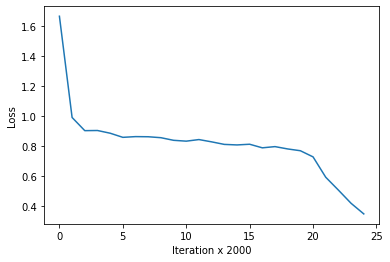

In [13]:
plt.xlabel("Iteration x 2000")
plt.ylabel("Loss")
end = data + data2
plt.plot(end)
plt.show()

In [14]:

performance = []
for batch, data in enumerate(data_loader,0):
    inputs, label = data
    prediction = model(inputs)
    prediction = prediction.detach().numpy()
    
    if np.argmax(prediction) == label.item():
        performance.append(1)
    else:
        performance.append(0)
    
    if batch == len(data_loader)-1:
        break
        
import statistics
print(f"Performance {statistics.mean(performance)}")

Performance 1
